#### Script to plot firing rate between dot offset and reward delivery for each neuron in a session.

**Prerequisites**
- Install python environment 'spikeinterface_fnt'
- Run script to create a data frame with harp timestamps aligned to key behavioural events.
- Run spike sorting pipeline for the session of interest.

**Inputs:**
- Output from Kilosort spike-sorting in a subfolder (specified by the user) within the session folder.
- Raw Open-ephys data within session folder.

**Key outputs**


**Overview** 
1. Read (or create) sorting analyzer object
2. Extract firing rates for all (good) units based on spike sorting


**Configure directory parameters**

In [2]:
import os
import glob
import spikeinterface.core as sc
import pandas as pd
import numpy as np

#==============================================================================
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'

# path behavioural data on ceph repo
input_root_dir = "W:/projects/FlexiVexi/behavioural_data" 

# name of subfolder in session folder with desired Kilosort output
kilosort_subfolder = 'Kilosort3'
#==============================================================================

session_folder = os.path.join(input_root_dir, animal_ID, session_ID)


**Create sorting analyzer for session**

In [6]:
import spikeinterface.extractors as se

# Path to Kilosort output files within session folder
kilosort_folder = os.path.join(session_folder, kilosort_subfolder, 'sorter_output')

# Get output from spike sorting using Kilosort, keeping only good units (according to Kilosort's criteria)
sorting = se.read_kilosort(folder_path=kilosort_folder,keep_good_only=True)
print(sorting)

# Get path to Open-Ephys Record Node within session folder
matching_files = glob.glob(os.path.join(session_folder, '**', 'settings.xml'), recursive=True)
if matching_files:
    # Get the first matching file
    first_matching_file = matching_files[0]

    # Get the directory of the first matching file
    path_to_recording = os.path.dirname(first_matching_file)
else:
    print("No 'settings.xml' file found in the specified path.")
        
    # Get recording from open ephys
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

# Create sorting analyzer
sorting_analyzer = sc.create_sorting_analyzer(sorting, recording)

KiloSortSortingExtractor: 110 units - 1 segments - 30.0kHz


estimate_sparsity:   0%|          | 0/3271 [00:00<?, ?it/s]

**Plot raster of spikes for n units**

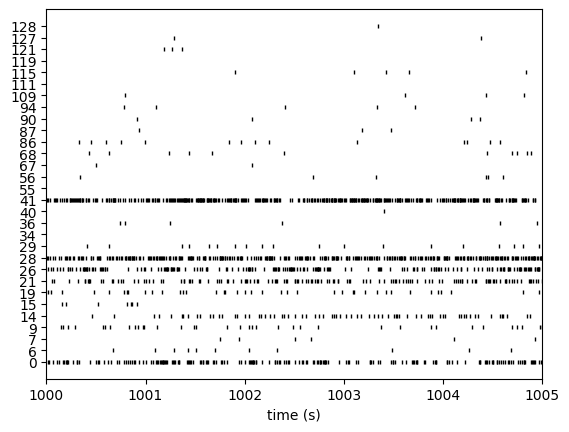

In [11]:
import spikeinterface.widgets as sw

n=30
unit_ids = sorting.get_unit_ids()

# Plot rasters for first n units in unit_ids
w_rs = sw.plot_rasters(sorting, time_range=(1000, 1005), unit_ids=unit_ids[:n])

**Get firing rates of an example neuron from a (non-overlapping) rectangular sliding window**

[50.0, 40.0, 60.0, 60.0, 70.0, 50.0, 40.0, 70.0, 60.0, 40.0, 60.0, 30.0, 60.0, 50.0, 60.0, 80.0, 80.0, 10.0, 90.0, 60.0, 50.0, 50.0, 40.0, 70.0, 70.0, 60.0, 70.0, 70.0, 40.0, 50.0, 70.0, 60.0, 70.0, 60.0, 40.0, 90.0, 20.0, 50.0, 110.0, 40.0, 50.0, 50.0, 50.0, 50.0, 80.0, 70.0, 60.0, 60.0, 60.0, 80.0, 60.0, 20.0, 50.0, 30.0, 40.0, 50.0, 30.0, 60.0, 60.0, 60.0, 60.0, 70.0, 60.0, 60.0, 30.0, 50.0, 60.0, 80.0, 60.0, 70.0, 60.0, 60.0, 90.0, 60.0, 60.0, 70.0, 40.0, 60.0, 50.0, 0.0, 50.0, 60.0, 60.0, 30.0, 50.0, 50.0, 90.0, 40.0, 70.0, 80.0, 80.0, 50.0, 40.0, 50.0, 60.0, 70.0, 30.0, 50.0, 70.0, 40.0]


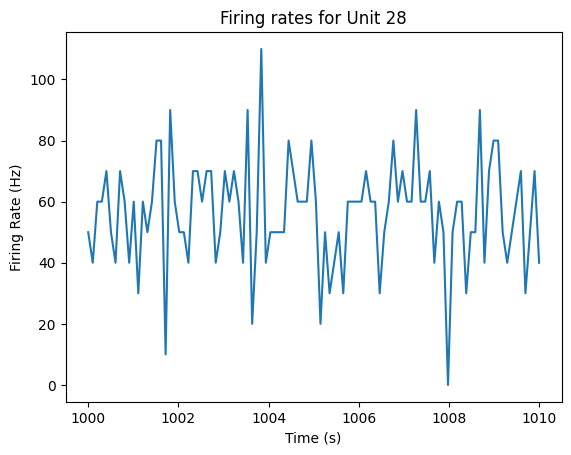

In [36]:
#==============================================================================
# USER CONFIGURATION
#==============================================================================

## Define the specific unit ID for which to calculate the firing rate
specific_unit_id = 28  # Replace with the desired unit ID

## Define duration of each window in seconds
window_size = 0.1

## Specify times over which sliding window should be applied to calculate  
##  changes in firing rate should be calculated.
t_start=1000
t_end=1010

#==============================================================================

# Retrieve the entire spike train for the specific unit
spike_train = sorting.get_unit_spike_train(
    unit_id=specific_unit_id, 
    return_times=True
    )

# Create window times
total_duration = t_end - t_start
num_windows = int(np.ceil(total_duration / window_size))
window_times = [(i * window_size, (i + 1) * window_size) for i in range(num_windows)]

# Align window times to spike times by adding recording start time
window_times = [(start + min(spike_train), end + min(spike_train)) for start, end in window_times]

# Compute firing rates for each window for the specific unit ID
firing_rates_per_window = []
for start, end in window_times:

    # Filter spikes within the current epoch
    window_spike_train = spike_train[(spike_train >= start) & (spike_train < end)]

    # Compute firing rate
    firing_rate = len(window_spike_train) / window_size
    firing_rates_per_window.append(firing_rate)

print(firing_rates_per_window)

# Plot firing rates over time
import matplotlib.pyplot as plt

plt.plot(np.linspace(t_start, t_end, num_windows), firing_rates_per_window)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing rates for Unit {}'.format(specific_unit_id))
plt.show()

**Get firing rates of an example neuron from a rectangular sliding window with overlap**

[50.0, 50.0, 40.0, 50.0, 60.0, 50.0, 60.0, 70.0, 70.0, 30.0, 50.0, 80.0, 40.0, 50.0, 70.0, 60.0, 60.0, 60.0, 40.0, 30.0, 60.0, 50.0, 30.0, 50.0, 60.0, 60.0, 50.0, 60.0, 60.0, 40.0, 80.0, 100.0, 80.0, 50.0, 10.0, 30.0, 90.0, 90.0, 60.0, 60.0, 50.0, 30.0, 50.0, 50.0, 40.0, 70.0, 70.0, 90.0, 70.0, 30.0, 60.0, 70.0, 70.0, 70.0, 70.0, 50.0, 40.0, 50.0, 50.0, 70.0, 70.0, 60.0, 60.0, 80.0, 70.0, 50.0, 60.0, 50.0, 40.0, 50.0, 90.0, 80.0, 20.0, 40.0, 50.0, 70.0, 110.0, 60.0, 40.0, 40.0, 50.0, 60.0, 50.0, 40.0, 50.0, 60.0, 50.0, 80.0, 80.0, 70.0, 70.0, 60.0, 60.0, 70.0, 60.0, 60.0, 60.0, 50.0, 80.0, 80.0, 60.0, 50.0, 20.0, 10.0, 50.0, 70.0, 30.0, 20.0, 40.0, 60.0, 50.0, 30.0, 30.0, 30.0, 60.0, 60.0, 60.0, 60.0, 60.0, 70.0, 60.0, 40.0, 70.0, 100.0, 60.0, 50.0, 60.0, 40.0, 30.0, 50.0, 50.0, 60.0, 60.0, 70.0, 80.0, 60.0, 60.0, 70.0, 70.0, 70.0, 60.0, 50.0, 60.0, 80.0, 90.0, 70.0, 60.0, 60.0, 60.0, 70.0, 70.0, 40.0, 40.0, 50.0, 60.0, 60.0, 50.0, 30.0, 0.0, 40.0, 50.0, 40.0, 60.0, 70.0, 60.0, 40.0, 3

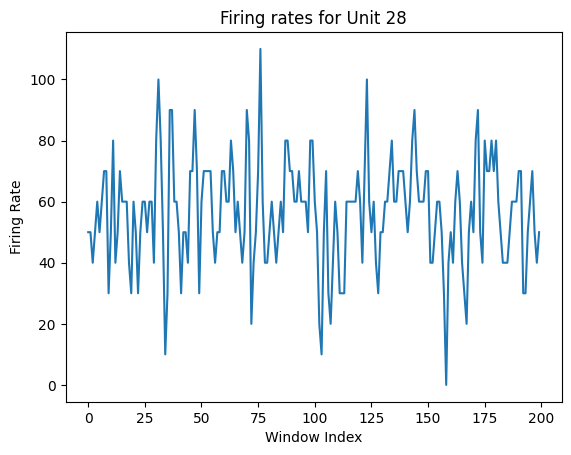

In [34]:
#------------------------------------------------------------------------------
# USER CONFIGURATION
#------------------------------------------------------------------------------

## Define the specific unit ID for which to calculate the firing rate
specific_unit_id = 28  # Replace with the desired unit ID

## Define duration of each window in seconds
window_size = 0.1   # 100ms window
overlap = 0.5    # 50% overlap

## Specify times over which sliding window should be applied to calculate  
##  changes in firing rate should be calculated.
t_start=1000
t_end=1010

#==============================================================================

# Retrieve the entire spike train for the specific unit
spike_train = sorting.get_unit_spike_train(unit_id=specific_unit_id, return_times=True)

# Create window times with 50% overlap
total_duration = t_end - t_start
window_step = window_size / 2  # 50% overlap
num_windows = int(np.ceil(total_duration / window_step))
window_times = [(i * window_step, i * window_step + window_size) for i in range(num_windows)]

# Align window times to spike times by adding recording start time
window_times = [(start + min(spike_train), end + min(spike_train)) for start, end in window_times]

# Compute firing rates for each window for the specific unit ID
firing_rates_per_window = []
for start, end in window_times:

    # Filter spikes within the current window
    window_spike_train = spike_train[(spike_train >= start) & (spike_train < end)]

    # Compute firing rate
    firing_rate = len(window_spike_train) / window_size
    firing_rates_per_window.append(firing_rate)

print(firing_rates_per_window)

# Plot firing rates over time
import matplotlib.pyplot as plt

plt.plot(np.linspace(t_start, t_end, num_windows), firing_rates_per_window)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing rates for Unit {}'.format(specific_unit_id))
plt.show()

**Plot firing rate of example unit over Gaussian sliding window $w$ with 50% overlap**

where the kernel $w$ used to calculate the firing rate at time $t$ is given by:
$$
w(t) = \frac{1}{\sqrt{2\pi} \sigma_{w}} \exp\left( -\frac{t^2}{2\sigma_{w}^2} \right),
$$
In which $\sigma_{w}$ determines the temporal resolution of the firing rate.